Set up a fully trained network in the NTK regime. We have a 1-hidden layer ReLU network.

$$
f_{W, a} (x)  = \dfrac{1}{\sqrt{m}} \sum_{i=1}^m a_r \sigma(w_r^\intercal x)
$$

The parameters are initialized randomly:
$$
w_r(0) \sim \mathcal{N}(0, \kappa^2 \mathbb{I}), a_r \sim \text{unif}(\{-1, 1 \}), \forall r \in [m]
$$

We fix the second layer $\mathbf{a}$ and optimize the first layer $\bf{W}$ on the quadratic objective function.
$$
\phi(\mathbf{W}) = \dfrac{1}{2} \sum_{i=1}^n (y_i - f_{\mathbf{W, a (x_i)}})^2
$$

In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from estimator import classical_weights, V1_inspired_weights_same_center
from data_fns import load_mnist, load_cifar_10, load_kmnist
from sklearn.model_selection import train_test_split

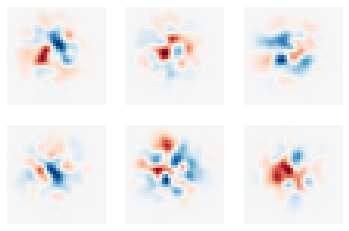

In [2]:
W = V1_inspired_weights_same_center(20, 1024, 5, 2, [14, 14])

fig = plt.figure()
for i in range(6):
    ax = fig.add_subplot(2, 3, i + 1)
    plt.imshow(W[i].reshape(32, 32), cmap='RdBu')
    plt.axis('off')
    cmap_lim = np.max(np.abs(W[i]))
    plt.clim(-cmap_lim, cmap_lim)

In [3]:
# load data
torch.cuda.set_device(0)
dataset = 'cifar10'
if dataset == 'mnist':
    train, train_labels, test, test_labels = load_mnist('./data/mnist/')
elif dataset == 'cifar10':
    train, train_labels, test, test_labels = load_cifar_10(grayscale=True)
elif dataset == 'kmnist':
    train, train_labels, test, test_labels = load_kmnist('./data/kmnist/') 

# convert data to tensors
train = torch.from_numpy(train).float().to('cuda')
train_labels = torch.from_numpy(train_labels).long().to('cuda')
test = torch.from_numpy(test).float().to('cuda')
test_labels = torch.from_numpy(test_labels).long().to('cuda')

# reshape
train_labels = train_labels.reshape(-1, 1)
test_labels = test_labels.reshape(-1, 1)

X_train, X_test, y_train, y_test = train, test, train_labels, test_labels

## Repeat similar experimental conditions as Du et. al. 2019. 
"Fine-Grained Analysis of Optimization and Generalization for Overparameterized Two-Layer Neural Networks "

In [4]:
# normalize inputs so that |x|_2 = 1
train /= torch.norm(train, dim=1).reshape(-1, 1)
test /= torch.norm(test, dim=1).reshape(-1, 1)

# load only the first two classes
train_idx = torch.logical_or(train_labels == 0, train_labels == 1).flatten()
test_idx = torch.logical_or(test_labels == 0, test_labels == 1).flatten()
train_binary = train[train_idx]

# We want label = 1 if first class and -1 otherwise.
# So we multiply original labels by -2 and add 1. Then, 0 -> 1, 1 -> -1
train_labels_binary = train_labels[train_idx] * -2 + 1
test_labels_binary = test_labels[test_idx] * -2 + 1

# We have 10k training samples and ~2k validation samples
X_test, y_test = test[test_idx], test_labels_binary
X_train, X_val, y_train, y_val = train_test_split(train_binary, train_labels_binary, train_size=9999, random_state=42)

In [5]:
# Set up the neural network. Hidden weights are trained but the output weights are fixed.
class NTK_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, kappa):
        super().__init__()
        self.hidden_size = hidden_size
        self.fc1 = nn.Linear(input_size, hidden_size)
        torch.nn.init.normal_(self.fc1.weight, mean=0, std=kappa ** 2)
        self.output = nn.Linear(hidden_size, output_size)
        torch.nn.init.uniform_(self.output.weight, a=-1, b=1)
        self.output.weight.requires_grad = False # freeze layer
        
    def forward(self, inputs):
        x = torch.relu(self.fc1(inputs))
        return 1 / np.sqrt(self.hidden_size) * self.output(x)

class bio_NTK_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, kappa):
        super().__init__()
        self.hidden_size = hidden_size
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc1.weight.data = torch.FloatTensor(V1_inspired_weights_same_center(hidden_size, input_size, t=5, l=2, m=[14, 14], 
                                                                                 scale=kappa ** 2))
        self.output = nn.Linear(hidden_size, output_size)
        torch.nn.init.uniform_(self.output.weight, a=-1, b=1)
        self.output.weight.requires_grad = False # freeze layer
        
    def forward(self, inputs):
        x = torch.relu(self.fc1(inputs))
        return 1 / np.sqrt(self.hidden_size) * self.output(x)

In [6]:
input_size, hidden_size, output_size, kappa = X_train.shape[1], 5000, 1, 1e-2
network = NTK_net(input_size, hidden_size, output_size, kappa).to('cuda')
bio_network = bio_NTK_net(input_size, hidden_size, output_size, kappa).to('cuda')

In [7]:
n_epochs, lr = 50000, 1e-3
loss_func = nn.MSELoss(reduction='sum')
loss_list = []
for i in range(n_epochs):
    optim = torch.optim.SGD(network.parameters(), lr=lr)
    optim.zero_grad()
    loss = loss_func(network(X_train), y_train.float()) / 2
    loss.backward()
    optim.step()
    loss_list.append(loss)
    if (i % 5000 == 0):
        print('Epoch: %d, loss=%0.3f' % (i, loss))

Epoch: 0, loss=4999.542
Epoch: 5000, loss=2665.056
Epoch: 10000, loss=2534.423
Epoch: 15000, loss=2434.110
Epoch: 20000, loss=2339.560
Epoch: 25000, loss=2257.910
Epoch: 30000, loss=2186.250
Epoch: 35000, loss=2123.071
Epoch: 40000, loss=2067.208
Epoch: 45000, loss=2018.182


In [8]:
n_epochs, lr = 50000, 1e-3 
loss_func = nn.MSELoss(reduction='sum')
loss_list_bio = []
for i in range(n_epochs):
    optim = torch.optim.SGD(bio_network.parameters(), lr=lr)
    optim.zero_grad()
    loss = loss_func(bio_network(X_train), y_train.float()) / 2
    loss.backward()
    optim.step()
    loss_list_bio.append(loss)
    if (i % 10000 == 0):
        print('Epoch: %d, loss=%0.3f' % (i, loss))

Epoch: 0, loss=4994.224
Epoch: 10000, loss=2064.999
Epoch: 20000, loss=1824.144
Epoch: 30000, loss=1671.936
Epoch: 40000, loss=1556.840


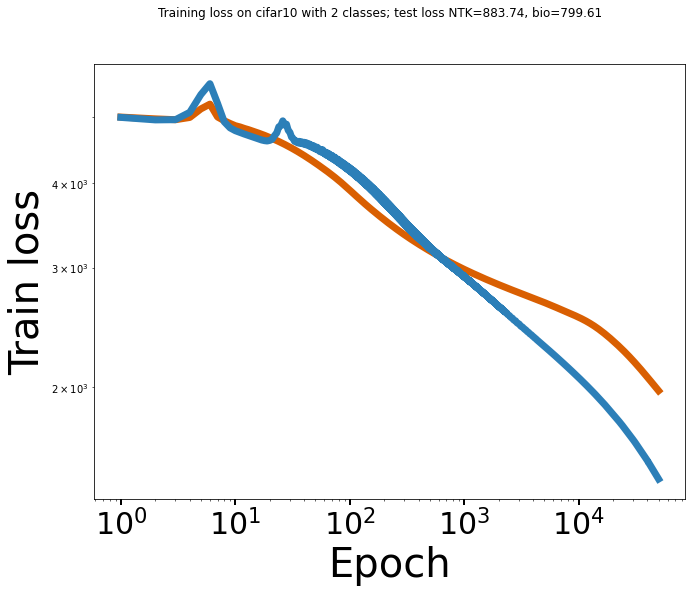

In [37]:
# ntk_test_loss = loss_func(network(X_test), y_test)
# bio_test_loss = loss_func(bio_network(X_test), y_test)
colors = {'NTK_bio': '#2c7fb8', 'NTK': '#d95f02'}

fig = plt.figure(figsize=(10.6, 8))
ax = fig.add_subplot(111)
t = np.arange(1, n_epochs + 1)
plt.suptitle('Training loss on %s with 2 classes; test loss NTK=%0.2f, bio=%0.2f' % (dataset, ntk_test_loss, bio_test_loss))
plt.loglog(t, loss_list, c=colors['NTK'], label='NTK', lw=7)
plt.loglog(t, loss_list_bio,  c=colors['NTK_bio'], label='bio NTK', lw=7)
plt.xlabel('Epoch', fontsize=40)
plt.ylabel('Train loss', fontsize=40)
# plt.yticks([10, 100, 1000, 10000])
# plt.xticks([1, 10, 100, 1000, 10000, 10000])
# plt.ylim([-0.05, 1.00])
# plt.xlim([1, 50000])
ax.tick_params(axis = 'both', which = 'major', labelsize = 30, width=2, length=6)
# plt.legend()
# plt.savefig('results/NTK_analysis/%s_train_loss_h=%d_fixed_center.png' % (dataset, hidden_size))

## kernel matrix analysis

In [23]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from estimator import V1_inspired_kernel_matrix
from data_fns import load_mnist, load_cifar_10
from sklearn.model_selection import train_test_split

In [24]:
dataset = 'cifar10'
if dataset == 'mnist':
    train, train_labels, test, test_labels = load_mnist('./data/mnist/')
elif dataset == 'cifar10':
    train, train_labels, test, test_labels = load_cifar_10(grayscale=True)
elif dataset == 'kmnist':
    train, train_labels, test, test_labels = load_kmnist('./data/kmnist/')   

# normalize inputs so that |x|_2 = 1
train /= la.norm(train, axis=1).reshape(-1, 1)
test /= la.norm(test, axis=1).reshape(-1, 1)

# load only the first two classes
train_idx = np.logical_or(train_labels == 0, train_labels == 1).flatten()
test_idx = np.logical_or(test_labels == 0, test_labels == 1).flatten()
train_binary = train[train_idx]

# We want label = 1 if first class and -1 otherwise.
# So we multiply original labels by -2 and add 1. Then, 0 -> 1, 1 -> -1
train_labels_binary = train_labels[train_idx] * -2 + 1
test_labels_binary = test_labels[test_idx] * -2 + 1

# We have 10k training samples and ~2k validation samples
X_test, y_test = test[test_idx], test_labels_binary
X_train, X_val, y_train, y_val = train_test_split(train_binary, train_labels_binary, train_size=5000, random_state=None)

### Analyze the projection of eigenvalues of NTK kernel matrix on the labels

We know that for the network presented above, the NTK matrix is 

$$
H^\infty_{ij} = \dfrac{x_i^\intercal x_j (\pi - \arccos(x_i^\intercal x_j))}{2 \pi}, \; \; \forall i, j \in [n]
$$

In [25]:
# bio-inspired kernel matrix
input_size, t, l, m = X_train.shape[1], 5, 2, [14, 14]
C = V1_inspired_kernel_matrix(input_size, t, l, m, scale=1)
C_chol = la.cholesky(C)
X_train_proj = X_train @ C_chol
X_train_proj /= la.norm(X_train_proj, axis=1).reshape(-1, 1)

In [26]:
# regualar NTK
H_inf = (X_train @ X_train.T) * (np.pi - np.arccos(X_train @ X_train.T)) / (2 * np.pi)
H_inf[np.isnan(H_inf)] = 1 / 2

H_inf_bio = (X_train @ X_train.T) * (np.pi - np.arccos(X_train_proj @ X_train_proj.T)) / (2 * np.pi) 
H_inf_bio[np.isnan(H_inf_bio)] = 1 / 2

<ipython-input-26-3506a0544d43>:2: RuntimeWarning: invalid value encountered in arccos
  H_inf = (X_train @ X_train.T) * (np.pi - np.arccos(X_train @ X_train.T)) / (2 * np.pi)
<ipython-input-26-3506a0544d43>:5: RuntimeWarning: invalid value encountered in arccos
  H_inf_bio = (X_train @ X_train.T) * (np.pi - np.arccos(X_train_proj @ X_train_proj.T)) / (2 * np.pi)


In [27]:
# find eigenvalues, eigenvectors of the kernel matrices
eig_val, eig_vec = la.eigh(H_inf)
eig_val_bio, eig_vec_bio = la.eigh(H_inf_bio)

# flip to arrange in descending order
eig_val, eig_vec = np.flip(eig_val), np.flip(eig_vec, 1)
eig_val_bio, eig_vec_bio = np.flip(eig_val_bio), np.flip(eig_vec_bio, 1)

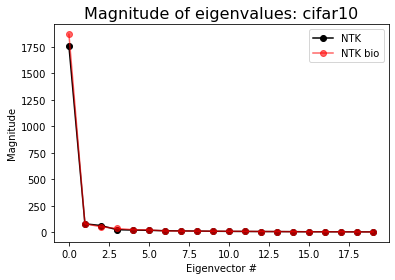

In [28]:
# plot eigenvalues
i = 20
fig = plt.figure()
plt.title('Magnitude of eigenvalues: %s' % dataset, fontsize=16)
plt.plot(eig_val[:i], 'k-o', label='NTK')
plt.plot(eig_val_bio[:i],'r-o', label='NTK bio', alpha=0.6)
plt.xlabel('Eigenvector #')
plt.ylabel('Magnitude')
# plt.xticks(np.arange(11))
plt.legend()
# plt.savefig('results/NTK_analysis/eigenvalues_%s.png' % dataset)

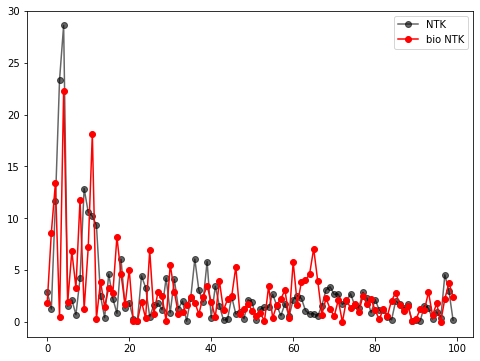

In [29]:
# find the projections of eigenvectors onto the data labels
proj = eig_vec.T @ y_train
proj_bio = eig_vec_bio.T @ y_train

i = 100
fig = plt.figure(figsize=(8, 6))
plt.plot(np.abs(proj)[:i], 'k-o', label='NTK', alpha=0.6)
plt.plot(np.abs(proj_bio)[:i], 'r-o', label='bio NTK')
plt.legend()
# plt.savefig('results/NTK_analysis/proj_eigenvecs_%s.png' % dataset)

In [30]:
# find the norm of the projections 
i = 5000
print('Norm for regular NTK', la.norm(np.abs(proj)[:i])) 
print('Norm for bio NTK', la.norm(np.abs(proj_bio)[:i]))    

Norm for regular NTK 70.71067811865477
Norm for bio NTK 70.71067811865476


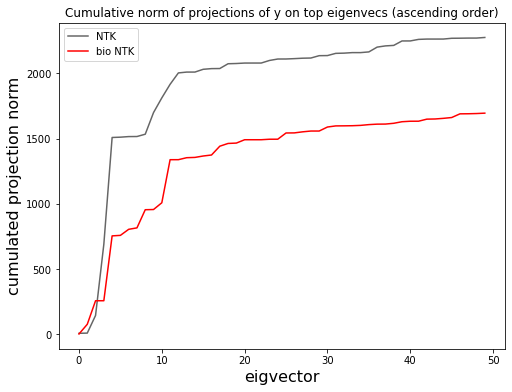

In [31]:
cum_norm_NTK = np.cumsum(proj ** 2)
cum_norm_NTK_bio = np.cumsum(proj_bio ** 2)

i = 50
fig = plt.figure(figsize=(8, 6))
plt.title('Cumulative norm of projections of y on top eigenvecs (ascending order)')
plt.plot(cum_norm_NTK[:i], 'k-', label='NTK', alpha=0.6)
plt.plot(cum_norm_NTK_bio[:i], 'r-', label='bio NTK')
plt.ylabel('cumulated projection norm', fontsize=16)
plt.xlabel('eigvector', fontsize=16)
plt.legend()

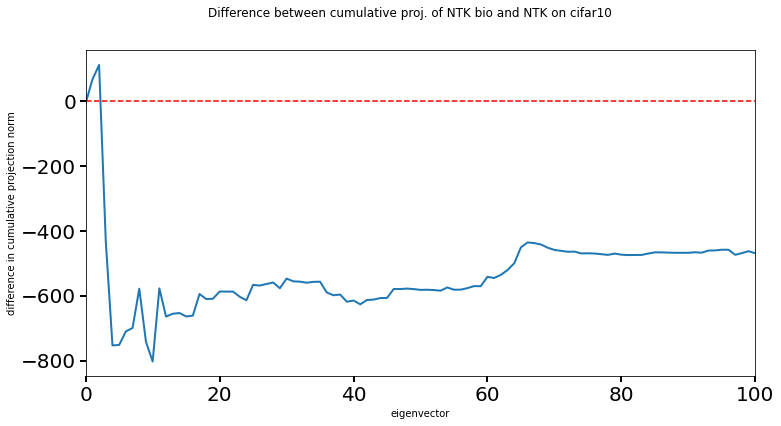

In [34]:
i = 100
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
plt.suptitle('Difference between cumulative proj. of NTK bio and NTK on %s' % dataset)
plt.plot(np.array(cum_norm_NTK_bio) - np.array(cum_norm_NTK), '-', label='NTK_bio - NTK', lw=2)
plt.plot(np.arange(5000), np.zeros(5000), '--r', label=r'$y = 0$')
plt.ylabel('difference in cumulative projection norm')
plt.xlabel('eigenvector')
ax.tick_params(axis = 'both', which = 'major', labelsize = 20, width=2, length=6)
plt.xticks(np.arange(0, 1200, 20))
# plt.yticks(np.arange(-100, 45, 20))
# plt.ylim([-100, 45])
plt.xlim([0, i])
# plt.legend()
plt.savefig('results/NTK_analysis/diff_cum_proj_eigenvecs_%s.png' % dataset)

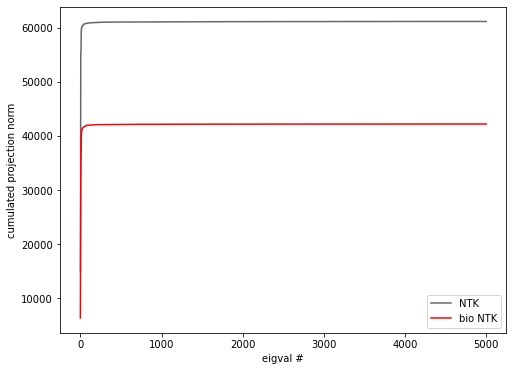

In [35]:
# find the projection times the eigenvalue square
proj_eigval = proj ** 2 * eig_val
proj_eigval_bio = proj_bio ** 2 * eig_val_bio

i = 5000
fig = plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(proj_eigval)[:i], 'k-', label='NTK', alpha=0.6)
plt.plot(np.cumsum(proj_eigval_bio)[:i], 'r-', label='bio NTK')
plt.ylabel('cumulated projection norm')
plt.xlabel('eigval #')
plt.legend()

In [ ]:
# plot cumulative sum of smallest eigenvalues
i = 5000
fig = plt.figure(figsize=(8, 6))
plt.semilogy(eig_val[::-1], 'k-', label='NTK', alpha=0.6)
plt.semilogy(eig_val_bio[::-1], 'r-', label='bio NTK')
plt.ylabel('cumulated sum of eigenvalues')
plt.xlabel('eigval #')
plt.legend()

In [ ]:
# look at the cumulative norm of the projections to eigenvecs in the ascending order
cum_norm_NTK_asc = np.cumsum(np.flip(proj) ** 2)
cum_norm_NTK_bio_asc = np.cumsum(np.flip(proj_bio) ** 2)

i = 5000
fig = plt.figure(figsize=(12, 6))
plt.title('Difference between cumulative proj. of NTK bio and NTK on %s' % dataset)
plt.plot(np.array(cum_norm_NTK_bio_asc)[:i] - np.array(cum_norm_NTK_asc)[:i], '-o', label='NTK_bio - NTK')
plt.plot(np.arange(5000)[:i], np.zeros(5000)[:i], '--r', label=r'$y = 0$')
plt.ylabel('difference in cumulative projection norm')
plt.xlabel('eigenvector')
# plt.xticks(np.arange(i))
plt.legend()


## Generalization bound for Gaussian kernel

In [ ]:
%pylab inline

$$f(\theta) = \sqrt{\frac{2y^TH^{-1}(\theta)y}{n}}$$ 
where
$$H(\theta)_{ij} = \frac{x_i^TC_\theta x_j\left(\pi - \arccos x_i^TC_\theta x_j\right)}{2\pi}$$
Let $x_i \in [0, 1]$ then the covariance matrix $C(\theta)$ assigns covariance coefficients to the coordinates of x that are exponentially decreasing with the distance. In other words, it makes an assumtion that nearly-placed coordinates of x are correltated:
$$C(\theta)_{ij} = \exp\left(-\frac{(i-j)^2}{2\theta^2n^2}\right)$$

In [ ]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from data_fns import load_mnist, load_cifar_10
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import pdist, squareform

In [ ]:
def cov_matrix(n, theta, scale=1):
    P = np.array([np.arange(n).tolist()] * n)
    C = np.exp(-(P - P.T)**2/(2 * theta ** 2 * n ** 2))
#     C *= (scale * n / np.trace(C))
#     C += 1e-7 * np.eye(n)
    return C

# def cov_matrix(n, theta, scale=1):
#     x = np.arange(np.sqrt(n))
#     yy, xx = np.meshgrid(x, x)
#     grid = np.column_stack((xx.flatten(), yy.flatten()))

#     dist = squareform(pdist(grid, 'sqeuclidean'))
#     C = np.exp(-dist / (2 * theta ** 2))
    
#     C += 1e-5 * np.eye(n)
#     C *= (scale * n / np.trace(C))
#     return C

def H_inf(X, theta, scale=1):
    n = X.shape[1]
    C = cov_matrix(n, theta, scale)
    L = la.cholesky(C)    
    Lx = X @ L
    Lx /= la.norm(Lx, axis=1).reshape(-1, 1)
    
    H = (X @ X.T) * (np.pi - np.arccos(Lx @ Lx.T)) / (2 * np.pi)
    H[np.isnan(H)] = 1 / 2 # replace NaN with 1/2
    return H

def gen_err_measure(X, y, theta, scale=1):
    n = X.shape[1]
    return y.T.dot(np.linalg.inv(H_inf(X, theta, scale))).dot(y) / n

def conv_measure(X, y, theta, scale=1):
    n = X.shape[1]
    return -y.T.dot(H_inf(X, theta, scale).dot(y))/ n

def joint_L(X, y, theta, lam=1e-6, scale=1):
    f = gen_err_measure(X, y, theta, scale=1)
    g = conv_measure(X, y, theta, scale=1)
    return (1-lam) * f + lam * g

In [ ]:
m = 100 # number of objects
n = 10  # number of features

# generate data
theta_true = 0.5
C_true = cov_matrix(n, theta_true, 1)
np.random.seed(42)
X = np.random.multivariate_normal(np.zeros(n), C_true, size=m) 
X = X / X.sum(axis=1, keepdims=True)
beta = np.random.rand(n)
y = X.dot(beta)

In [ ]:
C = cov_matrix(n, 40)

fig = plt.figure()
plt.imshow(C, cmap='RdBu')
plt.colorbar()

np.array([np.arange(n).tolist()] * n)

In [ ]:
theta_span = np.linspace(40, 1500, 10)
f_span, g_span, L_span = [], [], []

for i, theta in enumerate(theta_span):
    print('%d/%d' % (i, len(theta_span)))
    f_span.append(gen_err_measure(X, y, theta))
    g_span.append(conv_measure(X, y, theta))
    L_span.append(joint_L(X, y, theta))

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

In [ ]:
fig, (ax1, ax3) = plt.subplots(nrows=1, ncols=2, figsize=(24, 10))

color = 'tab:red'
ax1.set_xlabel(r'$l$')
ax1.set_ylabel('generalization bound', color=color)
ax1.plot(theta_span, f_span, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('initial slope', color=color)  # we already handled the x-label with ax1
ax2.plot(theta_span, g_span, color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax3.plot(theta_span, L_span, color="black")
ax3.set_xlabel(r'$l$')
ax3.set_ylabel('$J_\lambda(l)$, weighted criterion')
ax3.set_title(r"$J_\lambda(l)$ with $\lambda=1e5$")

fig.subplots_adjust(wspace=0.3)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [38]:
!nvidia-smi

Mon Mar 15 16:48:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.102.04   Driver Version: 450.102.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN Xp            Off  | 00000000:01:00.0 Off |                  N/A |
| 23%   26C    P8     9W / 250W |   1807MiB / 12196MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            Off  | 00000000:02:00.0 Off |                  N/A |
| 23%   